In [44]:
from dinosaur import spherical_harmonic
import jax
import matplotlib.pyplot as plt
import numpy as np
import neuralgcm
import optax
import pprint
import xarray

# 深入探討訓練模型

在論文中的圖1，我們可以看到NeuralGCM模型的結構。

![Figure 1](./figs_of_doc/neuralgcm-flowchart.jpg)

預訓練的模型可以被封裝好的`neuralgcm.PressureLevelModel`物件讀入，並進行操作。以下將介紹`encode()`、`decode()`和`advance()`方法，這些方法對應於學習到的轉換。

## 讀取模型

預訓練的NeuralGCM模型可以使用`from_checkpoint()`方法從文件中讀取，如在quick start中所示。這裡我們將toy model演示。

In [5]:
checkpoint = neuralgcm.demo.load_checkpoint_tl63_stochastic()
model = neuralgcm.PressureLevelModel.from_checkpoint(checkpoint)

## 載入資料

在Data Preparation中，已經介紹了如何對要進行預報的資料做處理，在此將使用經處理的範例資料為例。

In [ ]:
ds = neuralgcm.demo.load_data(model.data_coords)
ds_init = ds.isel(time=0)
inputs, forcings = model.data_from_xarray(ds_init)

此時，我們便有了inputs（預報變數）和forcings（強迫變數）的字典資料，以預報變數為例，如下：

In [10]:
inputs

{'geopotential': array([[[ 4.9768681e+05,  4.9768681e+05,  4.9709619e+05, ...,
           4.2238575e+05,  4.2298284e+05,  4.2298284e+05],
         [ 4.9769231e+05,  4.9769231e+05,  4.9705800e+05, ...,
           4.2246834e+05,  4.2302669e+05,  4.2302669e+05],
         [ 4.9769775e+05,  4.9769775e+05,  4.9701975e+05, ...,
           4.2255084e+05,  4.2307047e+05,  4.2307047e+05],
         ...,
         [ 4.9767450e+05,  4.9767450e+05,  4.9719450e+05, ...,
           4.2222053e+05,  4.2290000e+05,  4.2290000e+05],
         [ 4.9767853e+05,  4.9767853e+05,  4.9716816e+05, ...,
           4.2226659e+05,  4.2292034e+05,  4.2292034e+05],
         [ 4.9768269e+05,  4.9768269e+05,  4.9713219e+05, ...,
           4.2232619e+05,  4.2295159e+05,  4.2295159e+05]],
 
        [[ 4.3887162e+05,  4.3887162e+05,  4.3874756e+05, ...,
           3.7309050e+05,  3.7361578e+05,  3.7361578e+05],
         [ 4.3886956e+05,  4.3886956e+05,  4.3871369e+05, ...,
           3.7316778e+05,  3.7366084e+05,  3.73660

## 編碼為Sigma座標與解碼為氣壓座標

### 編碼

由於模型使用sigma座標來記錄當下大氣的狀態，因此在輸入了氣壓座標的資料後，需要將其以線性內差編碼為sigma座標，同時使用機器學習演算法濾除重力波。這可以使用`neuralgcm.PressureLevelModel.encode`方法來完成。若是隨機模型，則需要傳入一個JAX的RNG key，用來取樣隨機噪音。

In [13]:
encoded = model.encode(inputs, forcings, jax.random.key(0))

encoded

ModelState(state=StateWithTime(vorticity=Array([[[-9.84271150e-03, -1.78053174e-02,  1.34201407e-01, ...,
          7.71168843e-02, -6.49708137e-02,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -8.44406802e-03, -2.55766623e-02, ...,
         -5.23636490e-03, -1.44754108e-02, -0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.81673118e-03, -2.83316418e-04,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -1.48680678e-03, -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -1.48472755e-05, -0.00000000e+00]],

       [[-1.91478860e-02, -1.15641430e-02,  6.56953752e-02, ...,
          3.14277820e-02, -6.63434342e-02,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ..

### 解碼

我們可以使用`neuralgcm.PressureLevelModel.decode`來將Sigma座標的大氣狀態轉換為氣壓座標的大氣狀態。

In [15]:
decoded = model.decode(encoded, forcings)

decoded

{'geopotential': Array([[[ 3.3541341e+05,  3.3050550e+05,  3.2919409e+05, ...,
           2.7600872e+05,  2.7985562e+05,  2.7369891e+05],
         [ 3.3526894e+05,  3.3062366e+05,  3.2941419e+05, ...,
           2.7663391e+05,  2.7992272e+05,  2.7356109e+05],
         [ 3.3510709e+05,  3.3075938e+05,  3.2969966e+05, ...,
           2.7715688e+05,  2.7989819e+05,  2.7343334e+05],
         ...,
         [ 3.3543291e+05,  3.3013450e+05,  3.2854675e+05, ...,
           2.7440672e+05,  2.7915928e+05,  2.7414491e+05],
         [ 3.3552116e+05,  3.3027216e+05,  3.2882294e+05, ...,
           2.7480697e+05,  2.7946047e+05,  2.7399369e+05],
         [ 3.3550878e+05,  3.3039216e+05,  3.2901694e+05, ...,
           2.7536866e+05,  2.7969781e+05,  2.7384378e+05]],
 
        [[ 3.3033112e+05,  3.3125725e+05,  3.2959700e+05, ...,
           2.7553888e+05,  2.7506719e+05,  2.7626622e+05],
         [ 3.3024506e+05,  3.3123950e+05,  3.2980825e+05, ...,
           2.7595644e+05,  2.7515147e+05,  2.76213

不過需要注意的是，編解碼並非無損轉換。對於這一個預訓練模型，以氣溫為例，它在地表溫度上約有1度的誤差，如下所示：

In [16]:
abs(inputs['temperature'][-1] - decoded['temperature'][-1]).mean()

Array(1.2640882, dtype=float32)

## 對時間積分

`neuralgcm.PressureLevelModel.advance` 與 `neuralgcm.PressureLevelModel.unroll` 允許使用NeuralGCM 使用 Dynamic Core 和 Learned Physics的組合來將大氣狀態對時間積分。

`advance` 在時間上向前推進一個時間步長，通常是30或60分鐘：

In [ ]:
assert model.timestep == np.timedelta64(1, 'h') # 確保時間間隔是1小時，否則拋出錯誤

# 以編碼後的當前大氣狀態配合當前的強迫項進行一個時步的積分
advanced = model.advance(encoded, forcings)

`unroll` 是一個更高層次的方法，可以在一次性向前推進多個時間步長，並在給定的時間間隔後進行後處理並輸出該時刻的大氣狀態。

In [ ]:
# 以編碼後的當前大氣狀態配合當前的強迫項4個時步的積分，每個時步的時間間隔是1小時
all_forcings = model.forcings_from_xarray(ds)
advanced, outputs = model.unroll(
    encoded, 
    all_forcings, 
    steps=4, 
    timedelta=np.timedelta64(1, 'h')
    )

上面的`forcing`所具有的維度是不一樣的，其中一個不具有時間維度，另一個則有。這個的原因是因為如果使用unroll的話，強迫項可能會隨著時間變化，因此必須要有時間維度，不過，如果只是積分一個時步則不需要時間維度。

雖然強迫項必須要至少有一個時間維度，不過，如果只有一個時間點也是沒有關係的，強迫項會使用最接近預報時間點的強迫項來作為本次積分的強迫項，因此如果要在模擬時考慮強迫項會隨時間發生變化，可以令強迫項包含許多時間點，不過如果沒有也沒關係，他只會取該時間點作為強迫項。

## JAX 轉換（jit、grad等）

`neuralgcm.PressureLevelModel`物件是JAX pytrees，物件中的各個「葉」皆是可學習的類神經網路參數。這代表可以透過JAX的變換（例如`jax.jit`、`jax.grad`等）來組合出自定的NeuralGCM模型。

在此使用Optax來微調Toy Model，來盡量使encode前與decode後之誤差（重構誤差，Reconstruction Error）縮小。

In [ ]:
@jax.jit  # 編譯成JAX函數
def compute_loss(model, inputs, forcings, rng):
    # 將input編碼為encoded
    encoded = model.encode(inputs, forcings, rng_key=rng)
    # 將encoded解碼為restored
    restored = model.decode(encoded, forcings)
    # 計算restored和input的溫度的平均絕對誤差
    return abs(inputs['temperature'] - restored['temperature']).mean()

compute_loss(model, inputs, forcings, jax.random.key(0))

Array(6.225658, dtype=float32)

In [ ]:
optimizer = optax.adam(1e-3)  # 使用Adam優化器 1e-3是學習率
opt_model = model  # 優化後的模型，還沒開始優化，所以是原始模型
opt_state = optimizer.init(model)  # 初始化優化器狀態

# 進行5次優化迭代
for i in range(5):
    # 計算損失和梯度
    loss, grads = jax.value_and_grad(compute_loss)(
        opt_model, inputs, forcings, jax.random.key(0)
    )
    # 根據梯度與優化器狀態，計算模型參數要調整的量與新的優化器狀態
    updates, opt_state = optimizer.update(grads, opt_state)
    # 根據要調整的量，更新模型參數
    opt_model = optax.apply_updates(opt_model, updates)
    # 輸出迭代次數和損失
    print(f'{i=}, {loss=}')

i=0, loss=Array(6.225658, dtype=float32)
i=1, loss=Array(4.670498, dtype=float32)
i=2, loss=Array(3.855668, dtype=float32)
i=3, loss=Array(3.5485578, dtype=float32)
i=4, loss=Array(3.4335613, dtype=float32)


# 隨機擾動

NeuralGCM 的隨機模型使用 JAX 的[隨機數生成](https://jax.readthedocs.io/en/latest/jax.random.html)來產生隨機擾動

你可以使用`rng_key`參數來控制隨機擾動，對於非隨機模型，這個參數是可選的。如果要進行多次隨機預報，只需要傳入不同的RNG key即可，例如：

In [45]:
encoded1 = model.encode(inputs, forcings, jax.random.key(1))
encoded2 = model.encode(inputs, forcings, jax.random.key(2))

In [46]:
# 此時便會產生不同的溫度變異
encoded.state.vorticity.mean(), encoded2.state.vorticity.mean()

(Array(9.3231596e-05, dtype=float32), Array(9.325583e-05, dtype=float32))

Learned physics 中的隨機性也是透過相同的 `rng_key` 參數來控制的，這個參數會初始化模型狀態上的RNG key。你可以視覺化隨機擾動的高斯分不場：

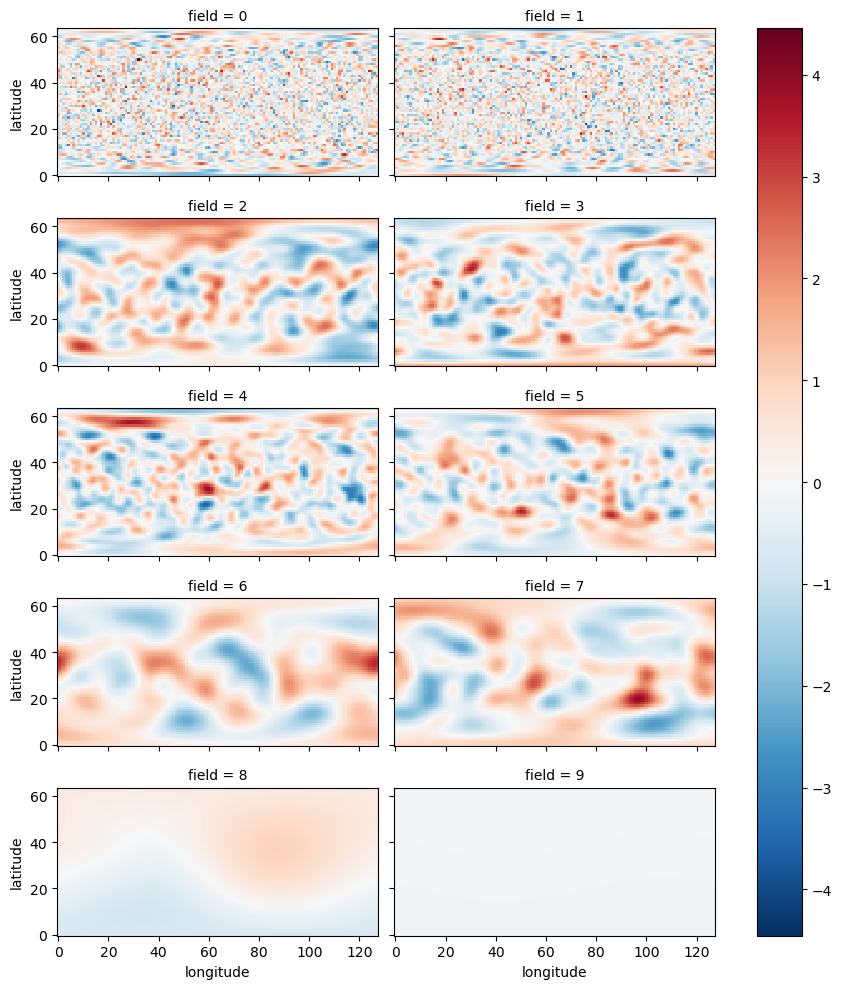

In [47]:
xarray.DataArray(
    encoded.randomness.nodal_value,
    dims=['field', 'longitude', 'latitude'],
).plot(x='longitude', y='latitude', col='field', col_wrap=2, aspect=2, size=2);

調整既有模型狀態上的隨機擾動也是可能的，只需要替換 `encoded.randomness.rng_key`，例如：

In [ ]:
encoded_with_new_rng = encoded.replace(
    randomness=encoded.randomness.replace(prng_key=jax.random.key(123))
    )